<a href="https://colab.research.google.com/github/tfjonas/ggnn_fault_loc/blob/master/ggnn_fault_loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://$GITHUB_AUTH@github.com/tfjonas/ggnn_fault_loc.git

Cloning into 'ggnn_fault_loc'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 4), reused 30 (delta 4), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [2]:
%cd /content/ggnn_fault_loc/
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

_dir_ = '/content/ggnn_fault_loc/dataset/'

TrainDataset = torch.load(_dir_ + 'train_dataset.pt')
TestDataset = torch.load(_dir_ + 'test_dataset.pt')
UnrelatedDataset = torch.load(_dir_ + 'unrelated_dataset.pt')
graphs = torch.load(_dir_ + 'graphs.pt')
graph_dict = torch.load(_dir_ + 'graph_dict.pt')
adj_matrices = torch.load(_dir_ + 'adj_matrices.pt')
dist_matrices = torch.load(_dir_ + 'dist_matrices.pt') 

/content/ggnn_fault_loc


# Train new model

In [0]:
%cd /content/ggnn_fault_location_/
_dir_ = '/content/ggnn_fault_location_/data/'

import torch
from model import GGNN
from utils import utils

EPOCHS = 60
BATCH_SIZE = 15
STEPS_PER_EPOCH = int((len(TrainDataset)/BATCH_SIZE) * 3)

PROPAG_STEPS = 60

model, opt, stat = utils.train_model(GGNN.GGNNModel(4, 64, PROPAG_STEPS).cuda(), 
                                     BATCH_SIZE, EPOCHS, STEPS_PER_EPOCH,
                                     TrainDataset, TestDataset, UnrelatedDataset,
                                     adj_matrices, dist_matrices)
    
file_name = '64x'+str(PROPAG_STEPS)+'_'+str(EPOCHS)+'E_'+str(STEPS_PER_EPOCH)+'B_'+str(BATCH_SIZE)+'S'


torch.save(model.state_dict(), file_name + '_model_state_dict.pt')
torch.save(opt.state_dict(), file_name + '_optimizer_state_dict.pt')
torch.save(stat, file_name + '_training_statistics.pt')


# Load trained model

In [0]:
import torch
from model import GGNN
from utils import utils

# Instantiate model
model = GGNN.GGNNModel(4, 64, 60)

# Load trained model 
state_dict_file = '/content/ggnn_fault_loc/64x60_60E_119B_15S_model_state_dict.pt'
device = torch.device('cpu')
model.load_state_dict(torch.load(state_dict_file, map_location=device))
model.eval()

# Statistics
stat_file = '/content/ggnn_fault_loc/64x60_60E_119B_15S_training_statistics.pt'
stat = torch.load(stat_file)

# Plot predictions

In [0]:
import numpy as np
from utils import plots

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

data = DataLoader(TestDataset, batch_size=1, shuffle=True)
#data = DataLoader(UnrelatedDataset, batch_size=1, shuffle=True)
iterator = iter(data)

/content/ggnn_fault_loc/utils/plots.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1.0)


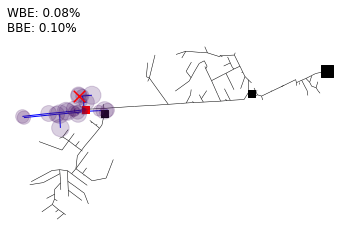

In [10]:
import matplotlib.pyplot as plt
from utils import errors
from utils import plots

model.eval()
X, T, graph_idx = next(iterator)
A = adj_matrices[graph_idx]
Y = model(X, A)

graph = graphs[graph_idx]
pred = np.exp(Y.detach().numpy())[0]
target = T.item()
devices = X[0,:,1].detach().numpy()

D = dist_matrices[graph_idx]
WBE = errors.weighted_bets_error(Y,T,D)
BBE = errors.biggest_bet_error(Y,T,D)

fig = plt.figure()
plt.title(('WBE: %.2f%% \nBBE: %.2f%%' % (WBE[1],BBE[1])), loc='left')
plots.plot_pred(graph, pred, target, devices)

# Plot statistics

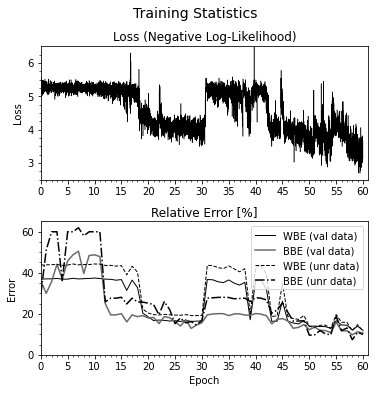

In [0]:
import numpy as np
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(2)
fig.tight_layout(pad=1.2)
fig.subplots_adjust(top=0.88)

fig.suptitle("Training Statistics", fontsize=14)
fig.set_figwidth(5.3)
fig.set_figheight(5.5)

ax1.set_title('Loss (Negative Log-Likelihood)')
ax1.plot(np.arange(0,60,1/119),stat['loss_ls'],linewidth=.5,color='k')
ax1.set_ylabel('Loss')
ax1.axis([0, 61, 2.5, 6.5])

ax1.set_xticks(np.arange(0, 61, 5.0))
ax1.set_xticks(np.arange(0, 60, 1), minor=True)
#ax1.set_yticks(np.arange(2.5, 6.5, 1))
ax1.set_yticks(np.arange(2.5, 6.5 ,.25), minor=True)

#ax1.grid(which='minor', alpha=0.2)
#ax1.grid(which='major', alpha=0.5)


ax2.set_title('Relative Error [%]')
ax2.plot(np.array(stat['WBE_ls'][1])*100,color='k',linewidth=1)
ax2.plot(np.array(stat['BBE_ls'][1])*100,color='dimgray',linewidth=1.5)
ax2.plot(np.array(stat['uWBE_ls'][1])*100,color='k',linestyle='--',linewidth=1)
ax2.plot(np.array(stat['uBBE_ls'][1])*100,color='k',linestyle='-.', linewidth=1.5)
ax2.set_ylabel('Error')
ax2.set_xlabel('Epoch')
ax2.set_xticks(np.arange(0, 61, 5.0))
ax2.axis([0, 61, 5, 65])


ax2.set_xticks(np.arange(0, 61, 5.0))
ax2.set_xticks(np.arange(0, 60, 1), minor=True)
#ax1.set_yticks(np.arange(2.5, 6.5, 1))
ax2.set_yticks(np.arange(0, 65, 5), minor=True)

#ax2.grid(which='minor', alpha=0.2)
#ax2.grid(which='major', alpha=0.5)

plt.legend(['WBE (val data)','BBE (val data)','WBE (unr data)','BBE (unr data)'])


fig.savefig("training.pdf", format='pdf', bbox_inches = 'tight')

In [0]:
import networkx as nx
import numpy as np

pred_up = []
pred_down = []
pred_fault = []
isc_diff = []

dataset = DataLoader(UnrelatedDataset, batch_size=1)
for sample in dataset:
    model.eval()
    X, T, graph_idx = sample
    A = adj_matrices[graph_idx]
    Y = model(X, A)

    graph = graphs[graph_idx]
    pred = np.exp(Y.detach().numpy())[0]
    target = T.item()
    devices = X[0,:,1].detach().numpy()
    isc1 = X[0,:,0].detach().numpy()*10000

    G = graph
    nx.set_node_attributes(G,0,'section')
    next_device = []
    for node in nx.dfs_preorder_nodes(G, list(devices).index(0.5)):
        if devices[node] == 1.5:
            next_device.append(node)
        G.nodes[node]['section'] = -1
    for dev in next_device:
        for node in nx.dfs_preorder_nodes(G, dev):
            G.nodes[node]['section'] = 1  

    section = nx.get_node_attributes(G,'section')
    section = np.array([section[n] for n in range(0,len(section))])

    up_section = np.where(section == 0)
    down_section = np.where(section == 1)
    fault_section = np.where(section == -1)

    if pred[up_section].any():
        pred_up.append(max(pred[up_section])) # 1st statament
    if pred[down_section].any():
        pred_down.append(max(pred[down_section])) # 2st statament

    # 3st statament
    pred_fault.append(pred[fault_section])
    isc_diff.append(isc1[fault_section] - isc1[target])


unr_pred_fault = np.concatenate(pred_fault)
unr_isc_diff = np.concatenate(isc_diff)


In [0]:
import networkx as nx
import numpy as np

pred_up = []
pred_down = []
pred_fault = []
isc_diff = []

dataset = DataLoader(TestDataset, batch_size=1)
for sample in dataset:
    model.eval()
    X, T, graph_idx = sample
    A = adj_matrices[graph_idx]
    Y = model(X, A)

    graph = graphs[graph_idx]
    pred = np.exp(Y.detach().numpy())[0]
    target = T.item()
    devices = X[0,:,1].detach().numpy()
    isc1 = X[0,:,0].detach().numpy()*10000

    #plots.plot_pred(graph, pred, target, devices)

    G = graph
    nx.set_node_attributes(G,0,'section')
    next_device = []
    for node in nx.dfs_preorder_nodes(G, list(devices).index(0.5)):
        if devices[node] == 1.5:
            next_device.append(node)
        G.nodes[node]['section'] = -1
    for dev in next_device:
        for node in nx.dfs_preorder_nodes(G, dev):
            G.nodes[node]['section'] = 1  

    section = nx.get_node_attributes(G,'section')
    section = np.array([section[n] for n in range(0,len(section))])

    up_section = np.where(section == 0)
    down_section = np.where(section == 1)
    fault_section = np.where(section == -1)

    if pred[up_section].any():
        pred_up.append(max(pred[up_section])) # 1st statament
    if pred[down_section].any():
        pred_down.append(max(pred[down_section])) # 2st statament

    # 3st statament
    pred_fault.append(pred[fault_section])
    isc_diff.append(isc1[fault_section] - isc1[target])


val_pred_fault = np.concatenate(pred_fault)
val_isc_diff = np.concatenate(isc_diff)


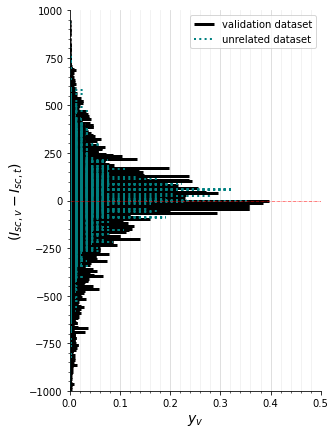

In [0]:
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(4.5,7))
ax = fig.add_subplot(1, 1, 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.hlines(val_isc_diff, [0], val_pred_fault, linewidth=3)
ax.hlines(unr_isc_diff, [0], unr_pred_fault, linewidth=2, 
          color='teal', linestyles=':', alpha=1)
ax.hlines(0, 0, 1, color='red', linestyles='-.', linewidth=.5)
ax.axis([0, .50, -1000, 1000])
ax.set_xlabel('$y_v$', fontsize=14)
ax.set_ylabel('$(I_{sc,v} - I_{sc,t})$', fontsize=14)

ax.set_xticks(np.arange(0, 0.51, 0.1))
ax.set_xticks(np.arange(0, 0.51, 0.02), minor=True)
ax.set_yticks(np.arange(-1000, 1000, 50), minor=True)

ax.xaxis.grid(which='minor', alpha=0.2)
ax.xaxis.grid(which='major', alpha=0.5)

ax.legend(['validation dataset', 'unrelated dataset'])

#ax.set_title('Difference between prospective short-circuit current at fault location and predicted nodes')

fig.savefig("isc.pdf", format='pdf', bbox_inches = 'tight')
